# Using LLMs to estimate "readability"

*Author: Sean Trott*

In this notebook, I set up and run code to use GPT-4, an LLM, to measure the readability of different text excerpts from the CLEAR corpus.


## Setup

### Import libraries

In [60]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats as ss
from tqdm import tqdm

from sklearn.preprocessing import StandardScaler

### Seaborn theme
sns.set_theme(style="white", palette='crest')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'  # makes figs nicer!

In [2]:
### Styling
# Get the Mako palette
palette = sns.color_palette("mako", 3)

# Select colors from opposite ends
color1 = palette[0]  # First color
color2 = palette[-1] # Last color
color3 = palette[3 // 2]

### Load CLEAR corpus

In [3]:
df = pd.read_csv("../data/CLEAR-Corpus/CLEAR_corpus_final.csv")
df.shape

(4724, 28)

### Set up GPT

In [4]:
from openai import OpenAI
import openai
client = OpenAI()

## Using GPT

### Helper functions

In [5]:
import backoff  # for exponential backoff

In [6]:
@backoff.on_exception(backoff.expo, openai.RateLimitError)
def pred_tokens(prompt, system_prompt, n=10, model="gpt-4", temperature = 0):
    """Get response."""
    completion = client.chat.completions.create(
      model=MODEL,
      messages=[
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": prompt}
      ],
        n = n,
        temperature = temperature
    )

    return completion# output['choices'][0]['message']['content']

In [7]:
### Helper functions
def is_number(s):
    try:
        float(s)
        return True
    except ValueError:
        return False

def get_number(ans):
    """Retrieves number from GPT-4 response."""
    if type(ans) is int:
        return ans
    res = [float(i) for i in ans.split() if is_number(i)]
    if len(res) == 0:
        return None
    return res[0]

### Method: Original Readability Measure

In this analysis, I give a general description of readability, and ask GPT-4 to produce a readability score. This is an example of "prompt engineering"; note that I did not make much effort to explore the space of prompts, so this should generally be considered a "local optimum" of what you could achieve using GPT-4.

In [85]:
### Format prompt with text. 
def format_prompt(instructions, text):
    final = instructions + "\n\n<Text>:{text}</Text>\n\nOn a scale from 1 (extremely challenging to understand) to 100 (very easy to read and understand), how readable is this text?. Please answer with a single number.".format(text = text)
    return final

In [86]:
### Set up system prompt and isntructions
system_prompt = "You are an experienced teacher, skilled at identifying the readability of different texts."
instructions = "Read the text below. Then, indicate the readability of the text, on a scale from 1 (extremely challenging to understand) to 100 (very easy to read and understand). In your assessment, consider factors such as sentence structure, vocabulary complexity, and overall clarity."


In [87]:
### Subset based on existing file
INDEX = 0
df_subset = df[INDEX:len(df)]
df_subset.shape

(4724, 28)

In [88]:
### Set up parameters
MODEL = "gpt-4-1106-preview"

### Open output .txt file
OUTPUT_PATH = "../data/processed/readability_basic_{m}.txt".format(m=MODEL)

In [89]:
results = []

df_subset = df[INDEX:len(df)]
for index, row in tqdm(df.iterrows(), total = len(df)):
    
    excerpt = row['Excerpt']
    
    ### Format using prompt
    prompt = format_prompt(instructions, excerpt)
    
    ### Obtain completion, allowing for backoff
    completion = pred_tokens(prompt = prompt, 
                             system_prompt = system_prompt,
                            n = 3,
                            model = MODEL)
    
    ### Replace newline characters to avoid text processing issues later
    text_modified = excerpt.replace('\n', '\\n')
    
    ### Write output to output file
    with open(OUTPUT_PATH, "a") as f:
        f.write("{excerpt}\t{response}\n".format(excerpt = text_modified, 
                                                response = completion.choices[0].message.content))
    
    ### Also track in DataFrame
    results.append({
        'Excerpt': excerpt,
        'GPT_Response': completion.choices[0].message.content
    })
    

100%|█████████████████████████████████████| 4724/4724 [2:48:55<00:00,  2.15s/it]


In [90]:
df_results = pd.DataFrame(results)

In [92]:
df_results.to_csv("../data/processed/readability_basic_{m}.csv".format(m=MODEL), index=False)

## Results

### Original readability measure

Now, we ask how well GPT-4's readability measure predicts our gold standard: `BT_easiness`. We compare this to the other formulaic measures included in the dataset, and also to the split-reliability measure reported in the text.

#### Load and process data

In [28]:
### Load .csv
df_results = pd.read_csv("../data/processed/readability_basic_gpt-4-1106-preview.csv")
df_results.shape

(4724, 2)

In [29]:
### Process numeric results
df_results['GPT_rating'] = df_results['GPT_Response'].apply(lambda x: get_number(x))
df_results['GPT_rating'].mean()

70.56731583403895

In [30]:
### Merge with original Dataframe
df_merged = pd.merge(df_results, df)
df_merged.shape

(4724, 30)

#### Descriptive statistics

In [31]:
df_merged['GPT_rating'].describe()

count    4724.000000
mean       70.567316
std        16.725857
min        20.000000
25%        60.000000
50%        75.000000
75%        85.000000
max       100.000000
Name: GPT_rating, dtype: float64

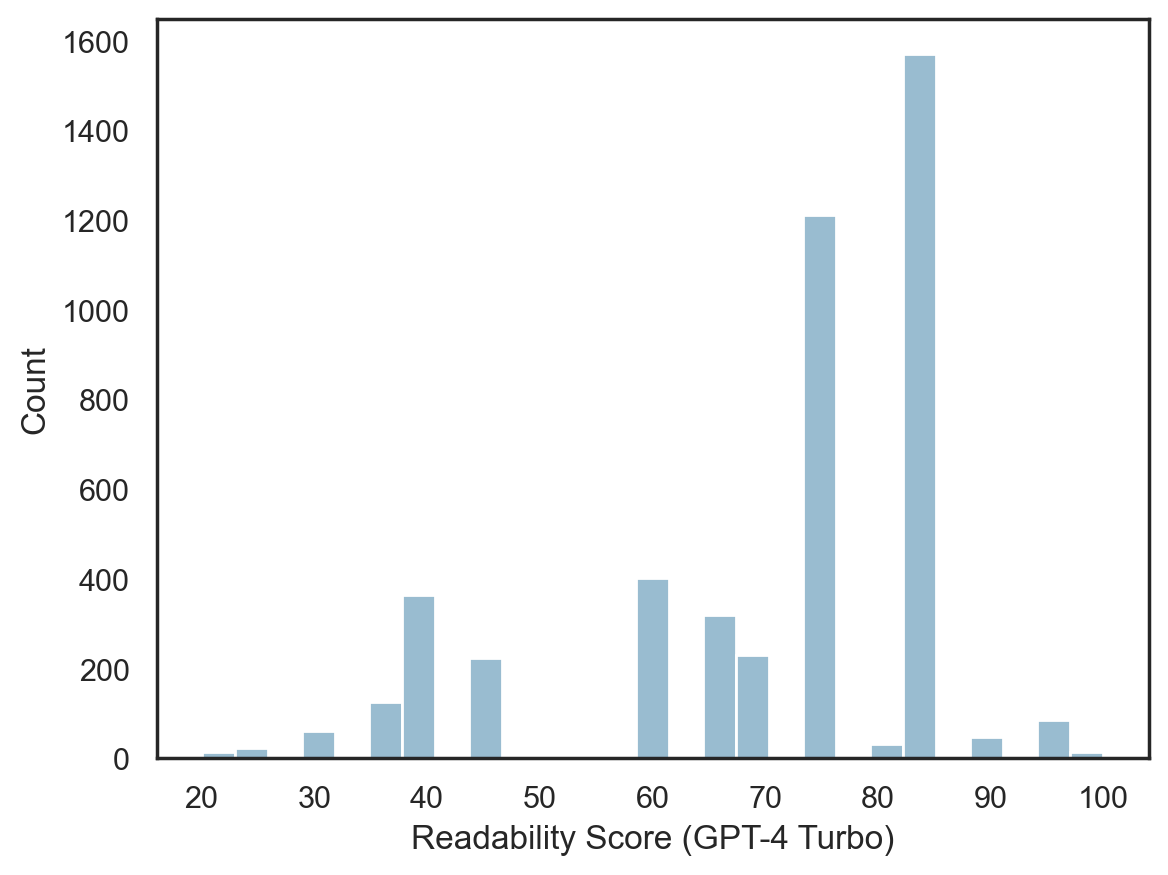

In [33]:
sns.histplot(data = df_merged, x = 'GPT_rating', alpha = .5, color = color3)
plt.xlabel("Readability Score (GPT-4 Turbo)")
plt.savefig("Figures/gpt4_scores.png", dpi = 300)

Text(0, 0.5, 'Readability Score (GPT-4 Turbo)')

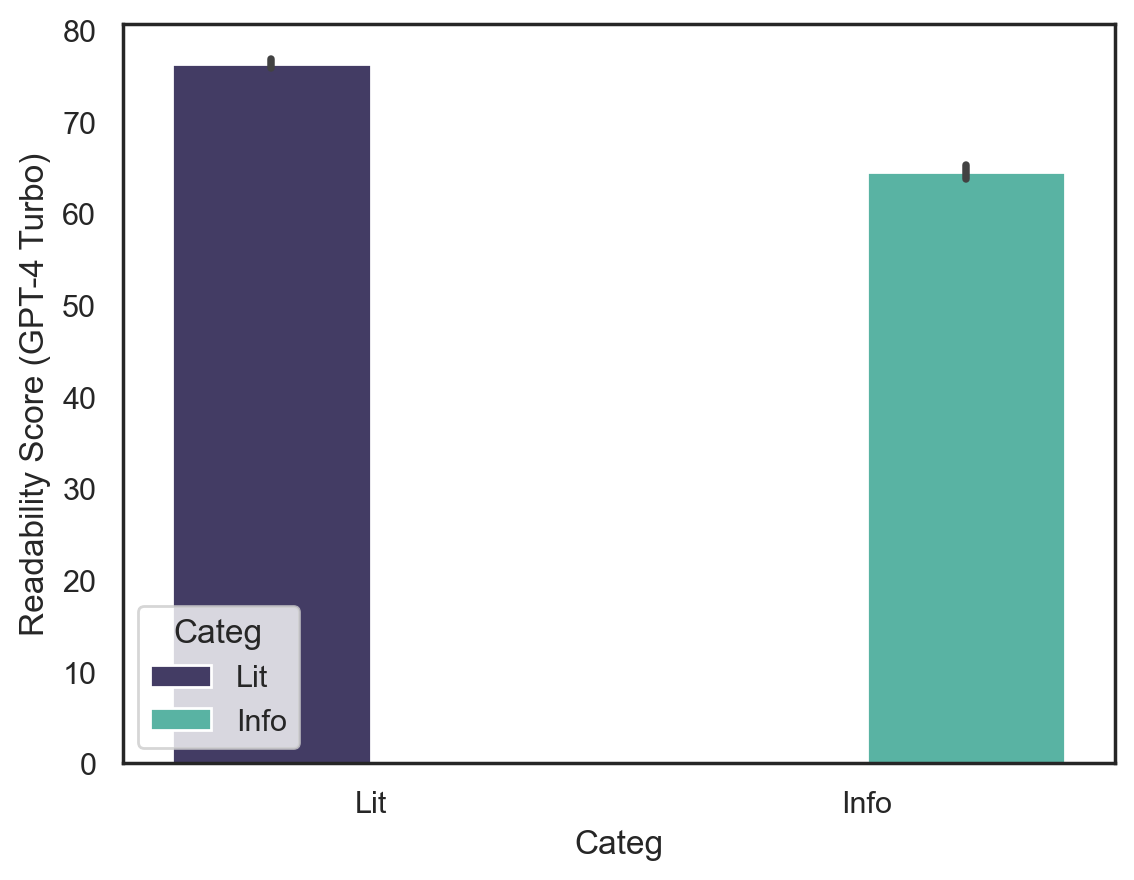

In [34]:
### GPT-4 rates literature as easier to read, on average
sns.barplot(data = df_merged, x = 'Categ', y = 'GPT_rating', hue = 'Categ',
               palette = [color1, color2])
plt.ylabel("Readability Score (GPT-4 Turbo)")

In [42]:
mod = smf.ols(data = df_merged, formula = "BT_easiness ~ GPT_rating").fit()
mod.params

Intercept    -4.285327
GPT_rating    0.047156
dtype: float64

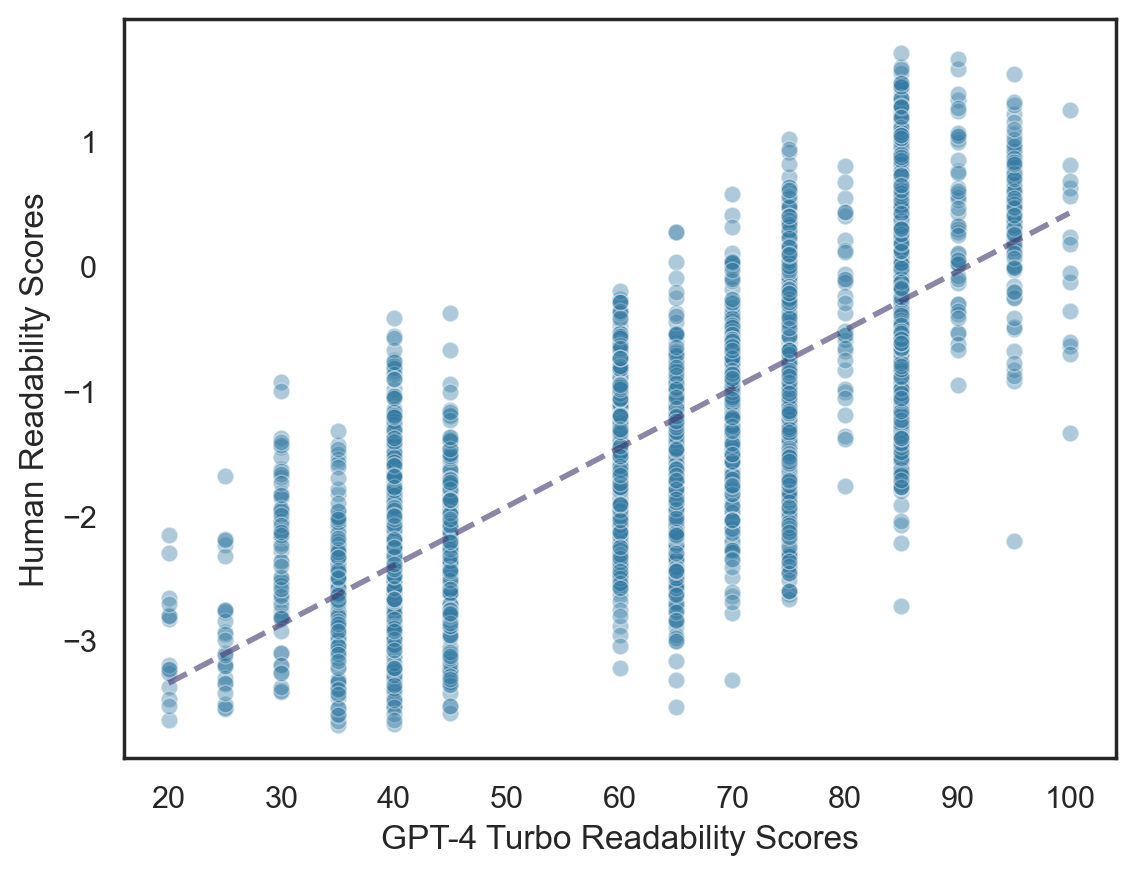

In [58]:
### GPT-4 vs. human readability scores
sns.scatterplot(data = df_merged, x = "GPT_rating", y = "BT_easiness", color = color3, alpha = .4)
plt.xlabel("GPT-4 Turbo Readability Scores")
plt.ylabel("Human Readability Scores")

### Plot predicitons
x = np.arange(20, 100, step = .1)
y = mod.params['Intercept'] + mod.params['GPT_rating'] * x
plt.plot(x, y, color = color1, linestyle = "dashed", alpha = .6, linewidth = 2)

plt.savefig("Figures/gpt_human.png", dpi = 300)

#### Correlation matrix

In [62]:
ss.pearsonr(df_merged['BT_easiness'], df_merged['GPT_rating'])

PearsonRResult(statistic=0.7630469009198535, pvalue=0.0)

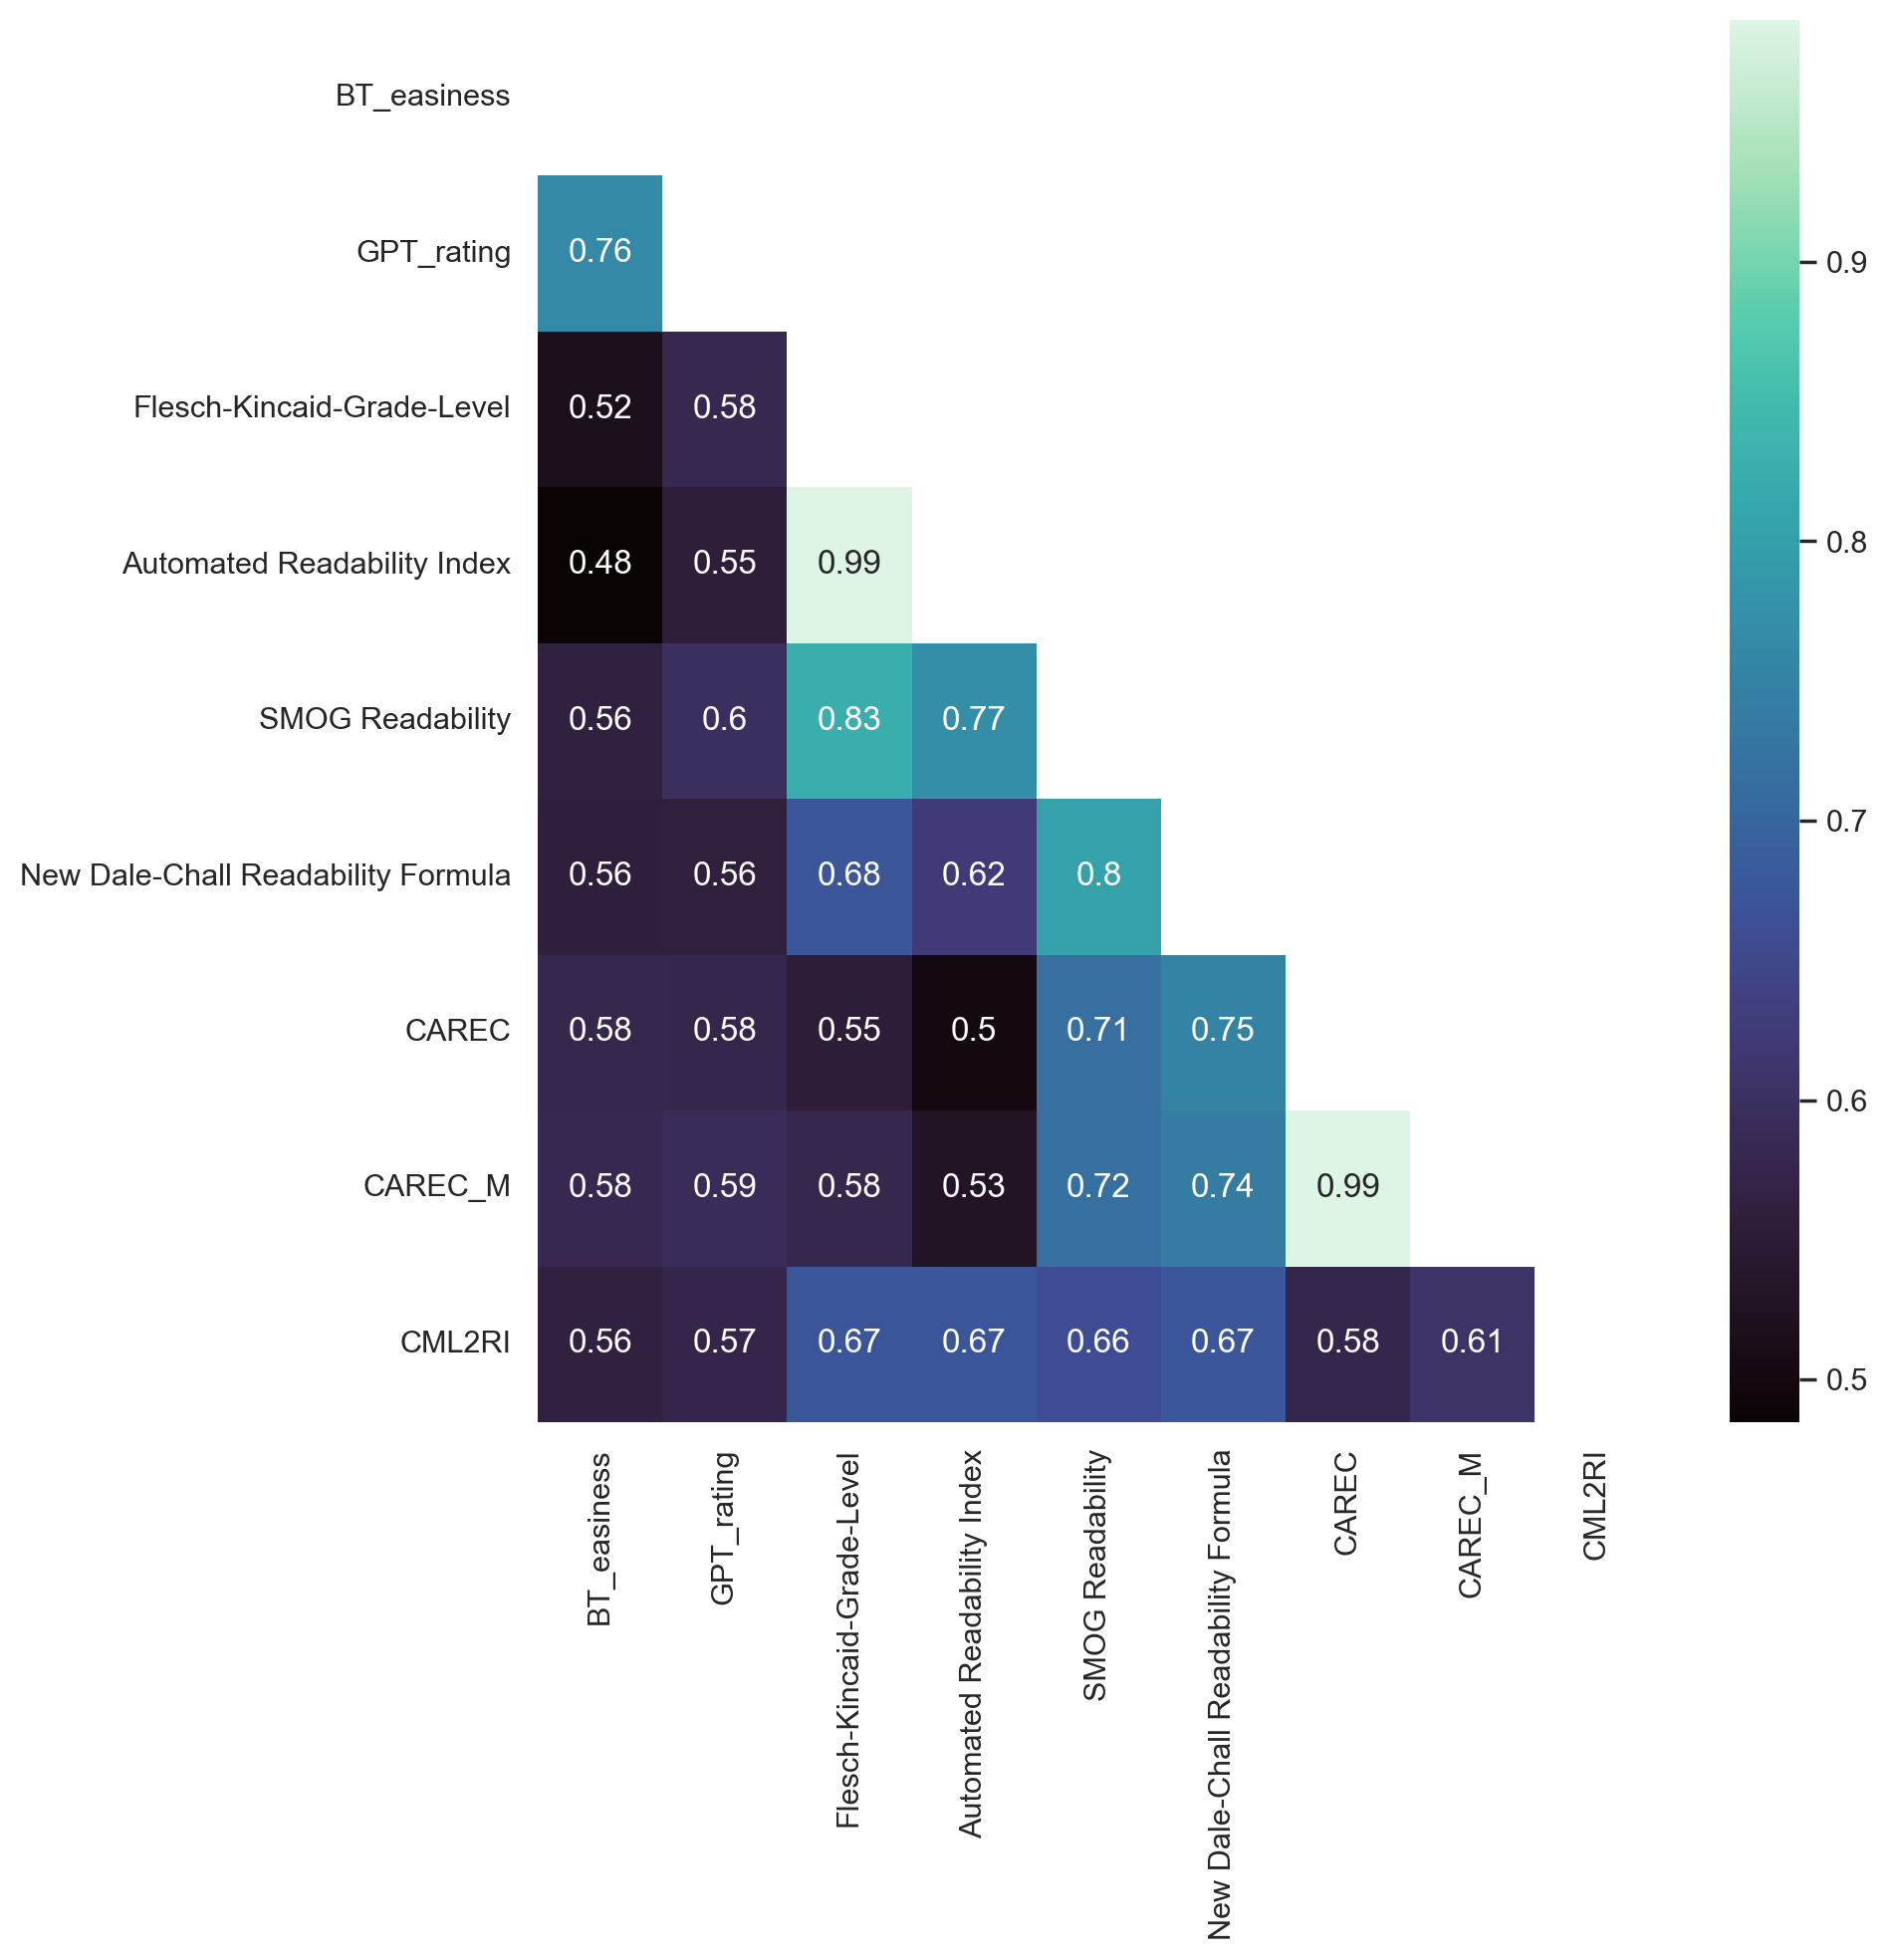

In [83]:
### Now, create a correlation matrix

df_subset = df_merged[[ 'BT_easiness', 'GPT_rating', 'Flesch-Kincaid-Grade-Level', 'Automated Readability Index',
               'SMOG Readability', 'New Dale-Chall Readability Formula', 'CAREC', 'CAREC_M', 'CML2RI']]
correlation_matrix = df_subset.corr()
plt.figure(figsize=(10, 10))

### Mask lower triangle
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
### Now plot using heatmap
sns.heatmap(np.abs(correlation_matrix), annot=True, cmap='mako', mask=mask)
plt.tight_layout()

plt.savefig("Figures/matrix.png", dpi = 300)

## Show
plt.show()



#### Statistical modeling

Now, we build a linear model predicting `BT_easiness` from a range of factors available in the dataset.

In [84]:
## Rename some variables for ease
df_merged['Word_count'] = df_merged['Google WC']
df_merged['Flesch'] = df_merged['Flesch-Reading-Ease']
df_merged['Sentence_count'] = df_merged['Sentence Count']
df_merged['ARI'] = df_merged['Automated Readability Index']
df_merged['SMOG'] = df_merged['SMOG Readability']
df_merged['NDC'] = df_merged['New Dale-Chall Readability Formula']

## Turn Category into a numeric variable
df_merged['Categ_numeric'] = df_merged['Categ'].apply(lambda x: 1 if x == 'Lit' else 0)

In [85]:
## Define features
features = ['Categ_numeric', 'GPT_rating', 'Paragraphs', 'Word_count',"Sentence_count", "Flesch-Reading-Ease", "ARI", "SMOG", "NDC", "CAREC_M", "CML2RI"]

# Get predictors and target
predictors = df_merged[features]  
target = df_merged['BT_easiness']

# Standardize the predictors
scaler = StandardScaler()
predictors_scaled = scaler.fit_transform(predictors)

# Add intercept
predictors_scaled = sm.add_constant(predictors_scaled)

# Fit the OLS model
model = sm.OLS(target, predictors_scaled).fit()

# Print the summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            BT_easiness   R-squared:                       0.641
Model:                            OLS   Adj. R-squared:                  0.640
Method:                 Least Squares   F-statistic:                     763.6
Date:                Thu, 01 Feb 2024   Prob (F-statistic):               0.00
Time:                        10:30:14   Log-Likelihood:                -4441.8
No. Observations:                4724   AIC:                             8908.
Df Residuals:                    4712   BIC:                             8985.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.9576      0.009   -106.094      0.0

<ErrorbarContainer object of 3 artists>

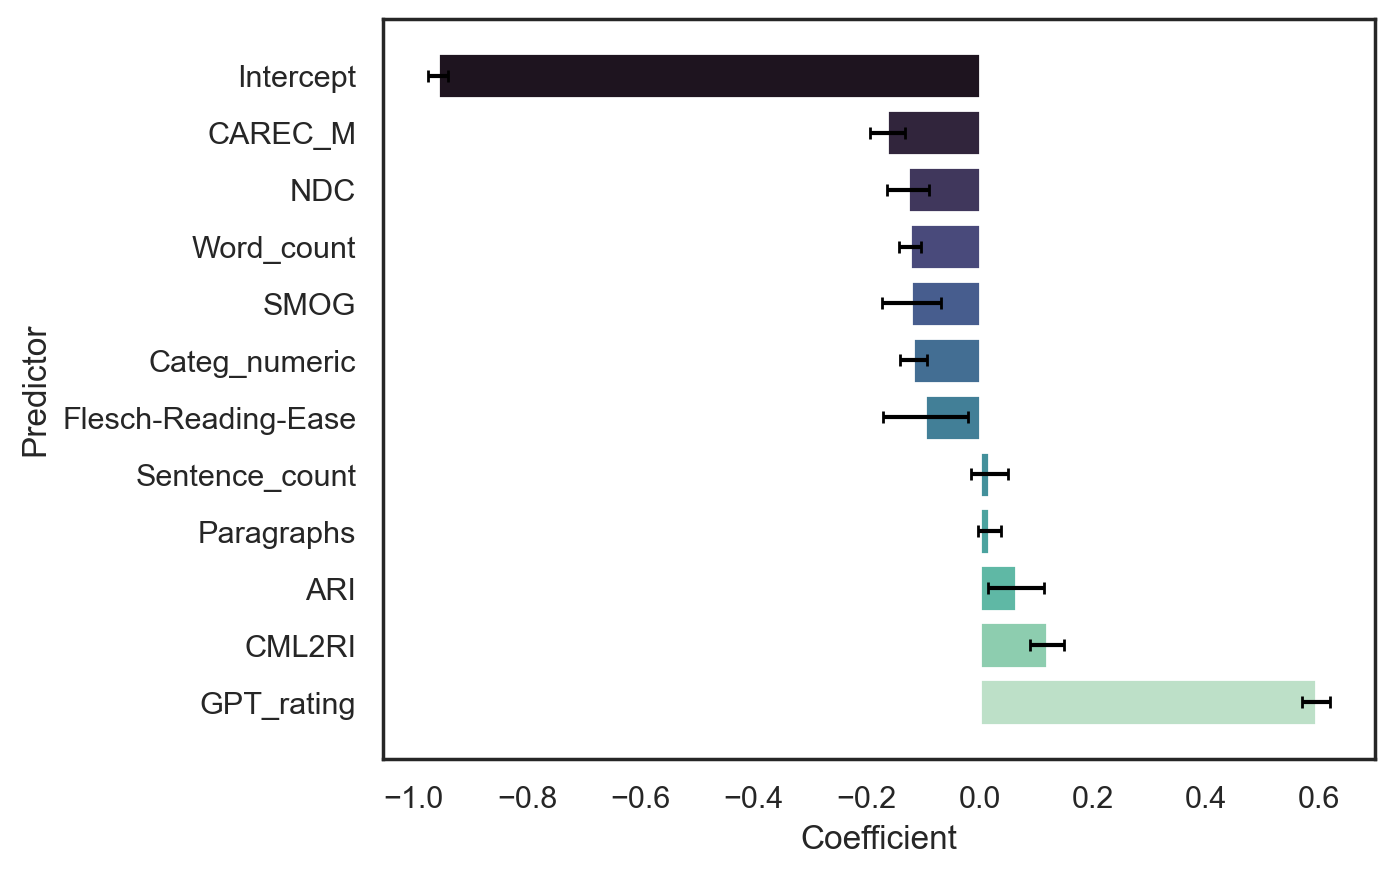

In [86]:
### Visualize coefficients
df_results = pd.DataFrame({
    'Coefficient': model.params,
    'Predictor': ['Intercept'] + features,
    'Standard Error': model.bse
})

df_results['CI'] = df_results['Standard Error'] * 1.96

### Plot results
df_results = df_results.sort_values("Coefficient")
### Pointplot
sns.barplot(data = df_results, y = "Predictor", x = "Coefficient", palette = "mako")
plt.errorbar(y = df_results['Predictor'], x = df_results['Coefficient'],
            xerr=df_results['CI'], fmt='none', c= 'black', capsize = 2)

### Identifying feature importances

Now, we use a few different approaches to ask whether `GPT_rating` is, in fact, a reliably useful feature for predicting `BT_easiness`.

- Feature importance scores for `RandomForestRegressor`.  
- Regularized coefficients using Lasso Regression.

In [96]:
from sklearn.ensemble import RandomForestRegressor
from sklearn import linear_model
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

##### Random forest regression

In [97]:
# Standardize the predictors
scaler = StandardScaler()
predictors_scaled = scaler.fit_transform(predictors)

### Set up
X = predictors_scaled
y = target

In [98]:
### Fit model, using no constraints on max_depth
clf = RandomForestRegressor(max_depth=None, random_state=0)
clf.fit(X, y)

RandomForestRegressor(random_state=0)

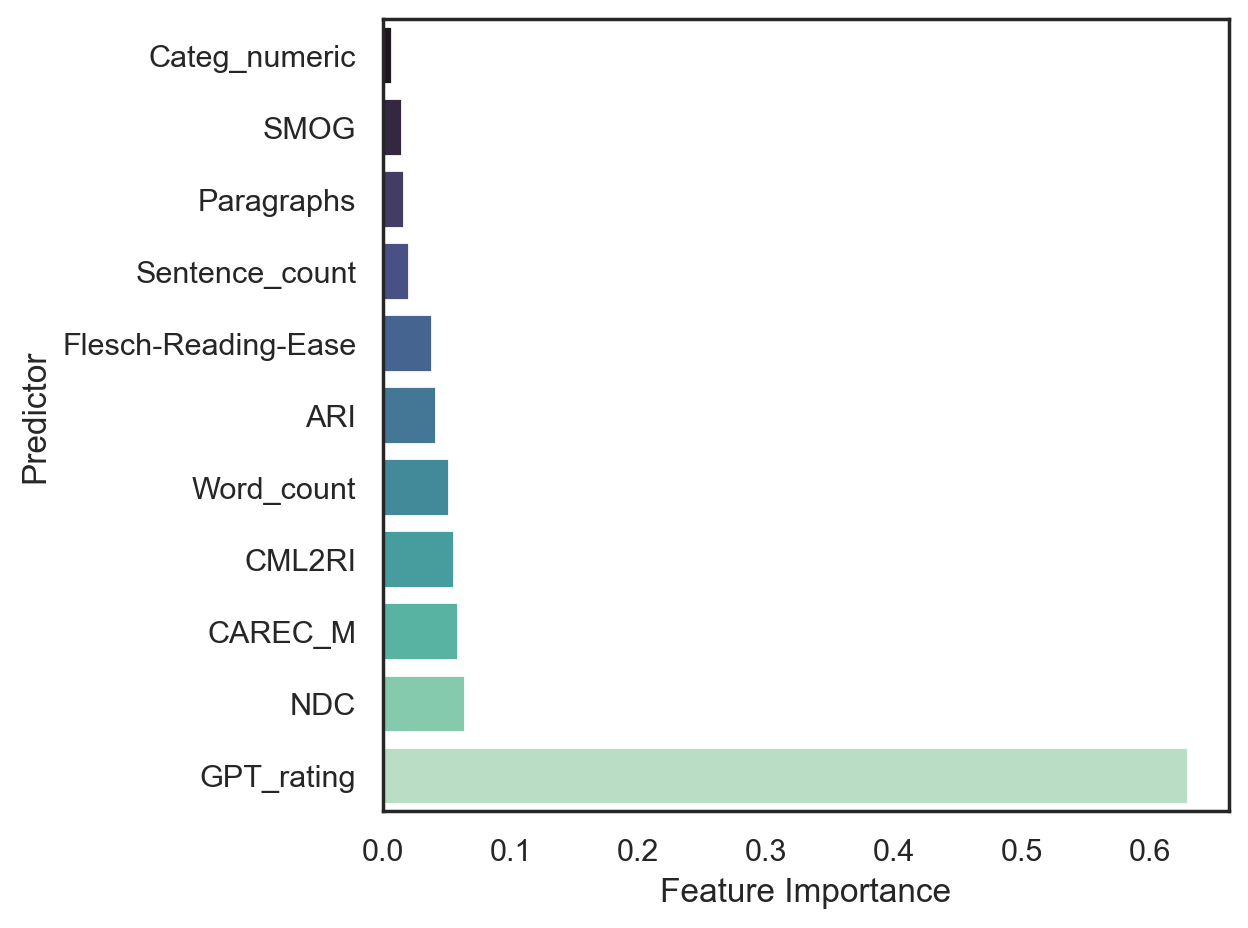

In [99]:
### Visualize coefficients
df_results = pd.DataFrame({
    'Feature Importance': clf.feature_importances_,
    'Predictor': features
})

### Plot results
df_results = df_results.sort_values("Feature Importance")
### Bar plot
sns.barplot(data = df_results, y = "Predictor", x = "Feature Importance", palette = "mako")

##
plt.tight_layout()
plt.savefig("Figures/rf_importance.png", dpi = 300)

##### Lasso Regression

In [92]:
### First, identify optimal `alpha` parameter. 
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(predictors_scaled, y, test_size=0.3, random_state=42)

# Create a LassoCV model instance
lasso_cv = LassoCV(alphas=np.logspace(-4, 4, 100), cv=5, random_state=42)

# Fit the model
lasso_cv.fit(X_train, y_train)

# Optimal alpha
optimal_alpha = lasso_cv.alpha_
print(f"The optimal alpha is: {optimal_alpha}")


The optimal alpha is: 0.0009326033468832199


[-0.11452494  0.59464567  0.01698166 -0.12139558  0.013358   -0.07877063
  0.06192247 -0.10801414 -0.121654   -0.16073969  0.11934326]
-0.9576386305268842


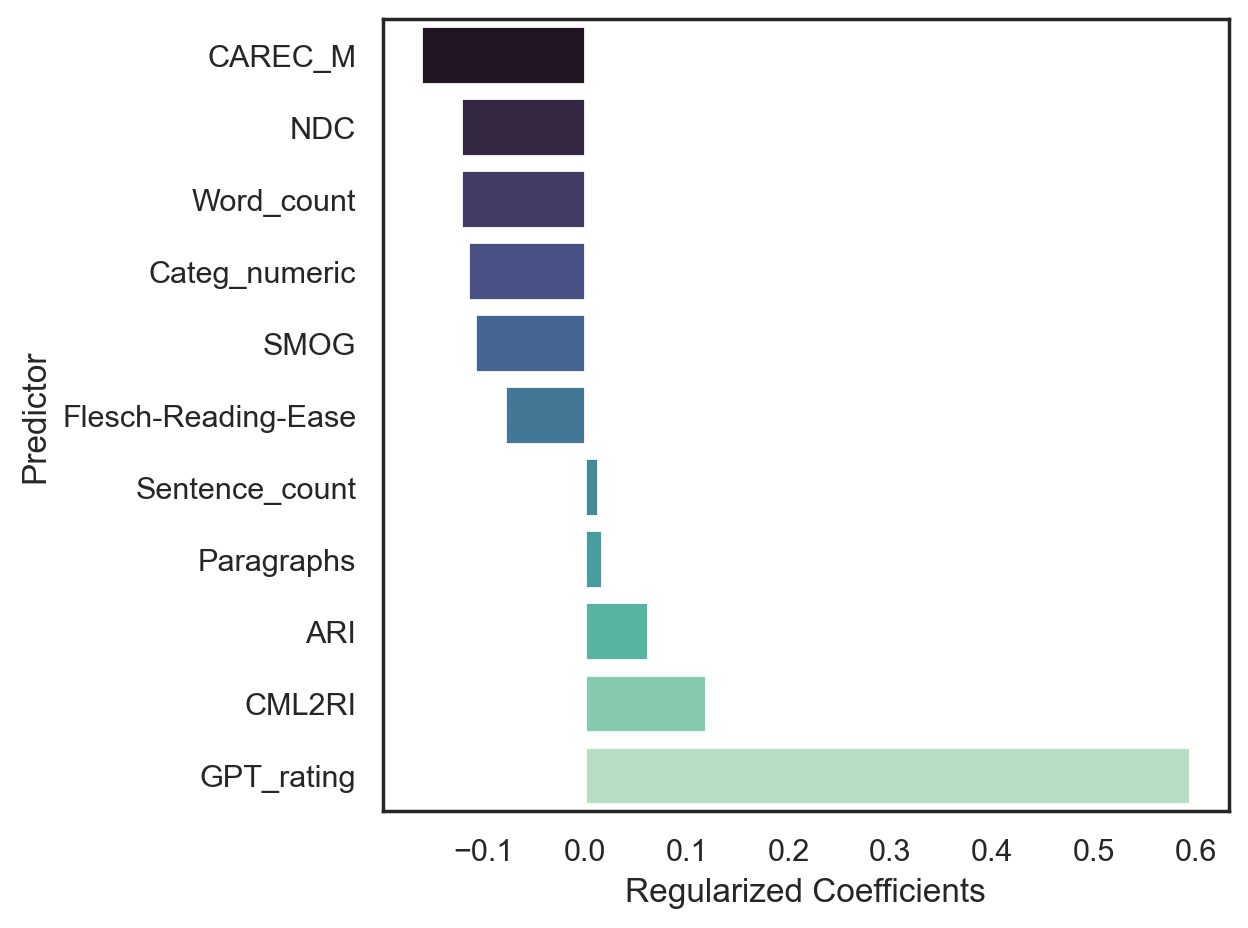

In [95]:
clf = linear_model.Lasso(alpha = lasso_cv.alpha_)
clf.fit(predictors_scaled, y)
print(clf.coef_)
print(clf.intercept_)

### Visualize coefficients
df_results = pd.DataFrame({
    'Regularized Coefficients': clf.coef_,
    'Predictor': features
})

### Plot results
df_results = df_results.sort_values("Regularized Coefficients")
### Bar plot
sns.barplot(data = df_results, y = "Predictor", x = "Regularized Coefficients", palette = "mako")

##
plt.tight_layout()
plt.savefig("Figures/lasso_scores.png", dpi = 300)